# Polarity

In [2]:
from scipy import sparse
from bluepysnap import Circuit
from graph_analysis.randomize import WeightPermutedRandomModel
from graph_analysis.rich_cub import RichClubAnalysis
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [3]:
file_format = 'pdf'
dpi = 300
save_dir = '../output/degree_and_polarity'
os.makedirs(save_dir,exist_ok=True)

# Calculate

In [4]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
synaptome = sparse.load_npz(adj_path)
connectome = synaptome.copy()
connectome[connectome > 0] = 1
# del synaptome

target = 'slice10'
CIRCUIT_DIR =  '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json'
circuit = Circuit(CIRCUIT_DIR)
nodes = circuit.nodes["hippocampus_neurons"]
edges = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical_synapse"]
target_indices = nodes.ids(target)
# target_synaptome = synaptome[target_indices,:][:,target_indices]
# target_connectome = connectome[target_indices,:][:,target_indices]

In [5]:
def polarity(OD,ID):
    return (ID-OD)/(ID+OD)

In [6]:
mtypes = list(np.unique(nodes.get().mtype))

In [7]:
polarity_dict = {}

for cur_mtype in tqdm(mtypes):
    mtype_indices = nodes.ids(cur_mtype)
    OD_conn = connectome[mtype_indices,:].sum() / mtype_indices.shape[0]
    OD_syn = synaptome[mtype_indices,:].sum() / mtype_indices.shape[0]
    ID_conn = connectome[:,mtype_indices].sum() / mtype_indices.shape[0]
    ID_syn = synaptome[:,mtype_indices].sum() / mtype_indices.shape[0]
    polarity_conn = polarity(OD_conn,ID_conn)
    polarity_syn = polarity(OD_syn,ID_syn)
    polarity_dict[cur_mtype] = {'OD_conn':OD_conn,'OD_syn':OD_syn,'ID_conn':ID_conn,'ID_syn':ID_syn,'polarity_conn':polarity_conn,'polarity_syn':polarity_syn}

In [8]:
import pandas as pd

In [9]:
df = pd.DataFrame.from_dict(polarity_dict, orient='index')
df.to_csv(os.path.join(save_dir,'polarity.csv'))

In [10]:
df

,OD_conn,OD_syn,ID_conn,ID_syn,polarity_conn,polarity_syn
SLM_PPA,531.698725,3015.972190,15.385863,70.848204,-0.943753,-0.954096
SO_BP,1197.041667,10938.304688,720.119792,4308.039062,-0.248765,-0.434876
SO_BS,1093.424274,6269.206432,608.020747,4606.922199,-0.285289,-0.152838
SO_OLM,1017.723379,10681.680241,1341.899849,3922.851584,0.137385,-0.462790
SO_Tri,1196.368163,9974.428471,645.166199,4163.241234,-0.299317,-0.411043
SP_AA,211.758452,1526.096530,547.766014,2362.471975,0.442392,0.215086
SP_BS,3144.117630,20544.627069,750.067383,4450.648853,-0.614776,-0.643881
SP_CCKBC,2209.961473,19363.522015,383.424499,1379.236523,-0.704306,-0.867015
SP_Ivy,1146.338734,14960.230761,581.607557,3207.628752,-0.326822,-0.646890
SP_PC,232.146769,529.273310,310.401501,1598.971611,0.144236,0.502620


# Plot

In [13]:
df = pd.read_csv(os.path.join(save_dir,'polarity.csv'),index_col=0)

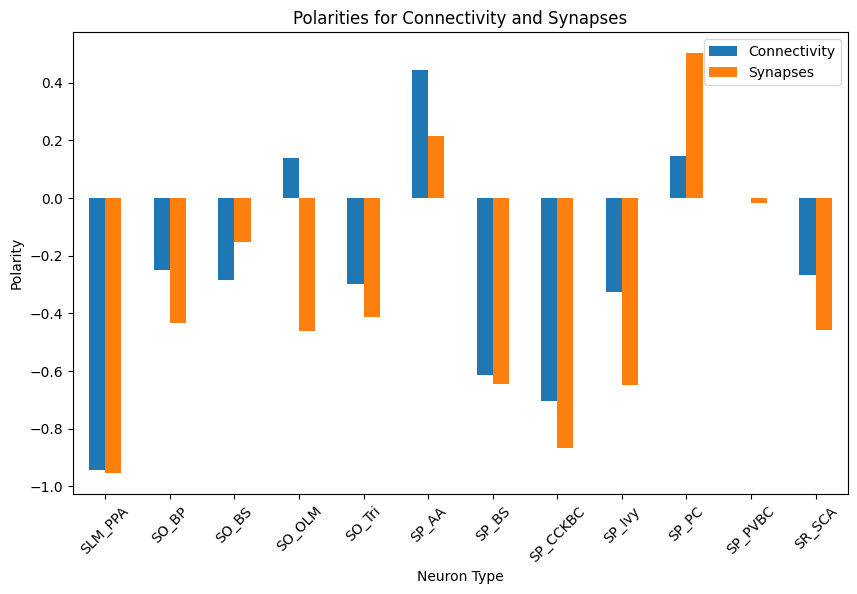

In [14]:
import matplotlib.pyplot as plt

# Selecting the relevant columns from the DataFrame
df_polarity = df[['polarity_conn', 'polarity_syn']]

# Plotting the bar plot
ax = df_polarity.plot(kind='bar', figsize=(10, 6))

# Adding labels and title
ax.set_xlabel('Neuron Type')
ax.set_ylabel('Polarity')
ax.set_title('Polarities for Connectivity and Synapses')

# Displaying the legend
ax.legend(['Connectivity', 'Synapses'])
# Rotating the x-axis labels for better readability (if necessary)
plt.xticks(rotation=45)

# Displaying the plot
plt.show()

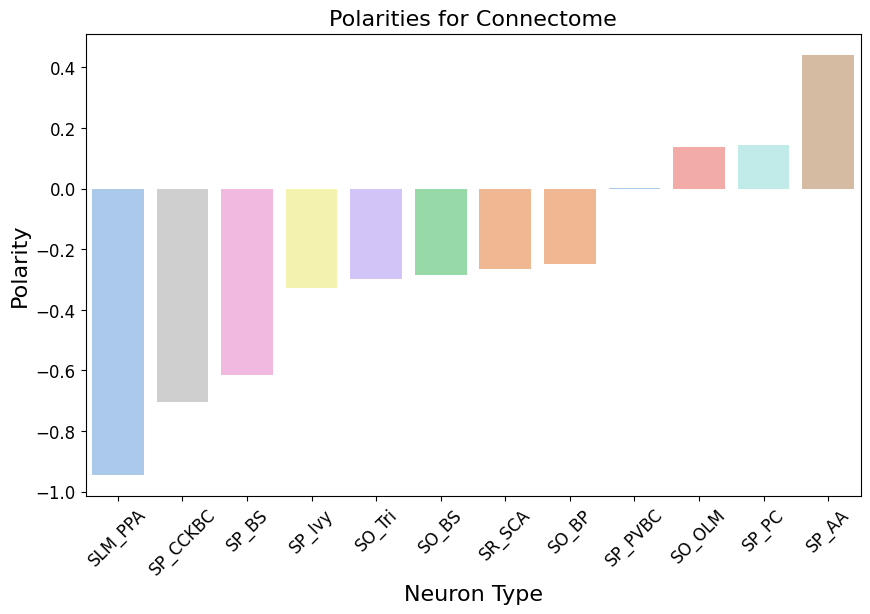

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the desired color palette based on the list of neuron types
neuron_types = ['SLM_PPA', 'SO_BP', 'SO_BS', 'SO_OLM', 'SO_Tri', 'SP_AA', 'SP_BS', 
                'SP_CCKBC', 'SP_Ivy', 'SP_PC', 'SP_PVBC', 'SR_SCA']
color_palette = sns.color_palette('pastel', len(neuron_types))
color_dict = dict(zip(neuron_types, color_palette))

# Sort the DataFrame by polarity_conn column in ascending order
df_sorted_conn = df.sort_values('polarity_conn')

# Plotting the bar plot for connectivity
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x=df_sorted_conn.index, y='polarity_conn', data=df_sorted_conn, palette=color_dict)

# Adding labels and title
ax1.set_xlabel('Neuron Type',fontsize=16)
ax1.set_ylabel('Polarity',fontsize=16)
ax1.set_title('Polarities for Connectome',fontsize=16)

# Rotating the x-axis labels for better readability (if necessary)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=45)
plt.savefig(f'{save_dir}/polarity_conn.{file_format}',dpi=300,format=file_format)
# Displaying the plot
plt.show()


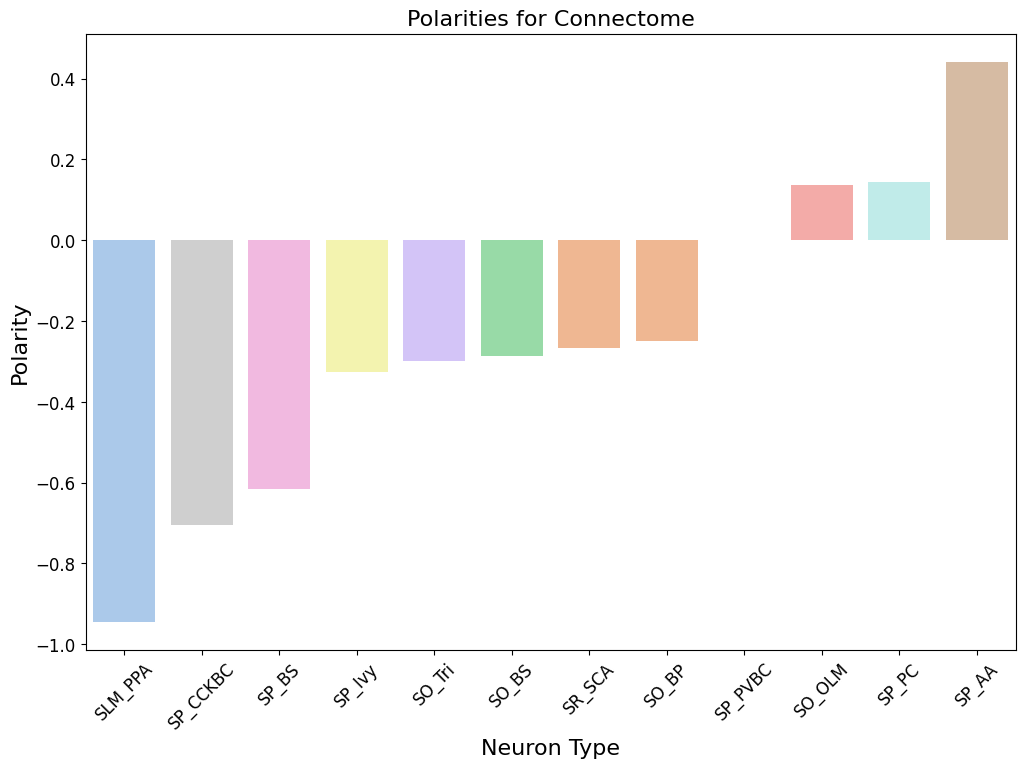

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the desired color palette based on the list of neuron types
neuron_types = ['SLM_PPA', 'SO_BP', 'SO_BS', 'SO_OLM', 'SO_Tri', 'SP_AA', 'SP_BS', 
                'SP_CCKBC', 'SP_Ivy', 'SP_PC', 'SP_PVBC', 'SR_SCA']
color_palette = sns.color_palette('pastel', len(neuron_types))
color_dict = dict(zip(neuron_types, color_palette))

# Sort the DataFrame by polarity_conn column in ascending order
df_sorted_conn = df.sort_values('polarity_conn')

# Increase the figure size to accommodate the xticklabels
plt.figure(figsize=(12, 8))

# Plotting the bar plot for connectivity
ax1 = sns.barplot(x=df_sorted_conn.index, y='polarity_conn', data=df_sorted_conn, palette=color_dict)

# Adding labels and title
ax1.set_xlabel('Neuron Type', fontsize=16)
ax1.set_ylabel('Polarity', fontsize=16)
ax1.set_title('Polarities for Connectome', fontsize=16)

# Rotating the x-axis labels for better readability (if necessary)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45)

# Increase the DPI for higher resolution
dpi = 600

# Save the figure with the updated figure size and DPI
plt.savefig(f'{save_dir}/polarity_conn.{file_format}', dpi=dpi, format=file_format, bbox_inches='tight')

# Displaying the plot
plt.show()


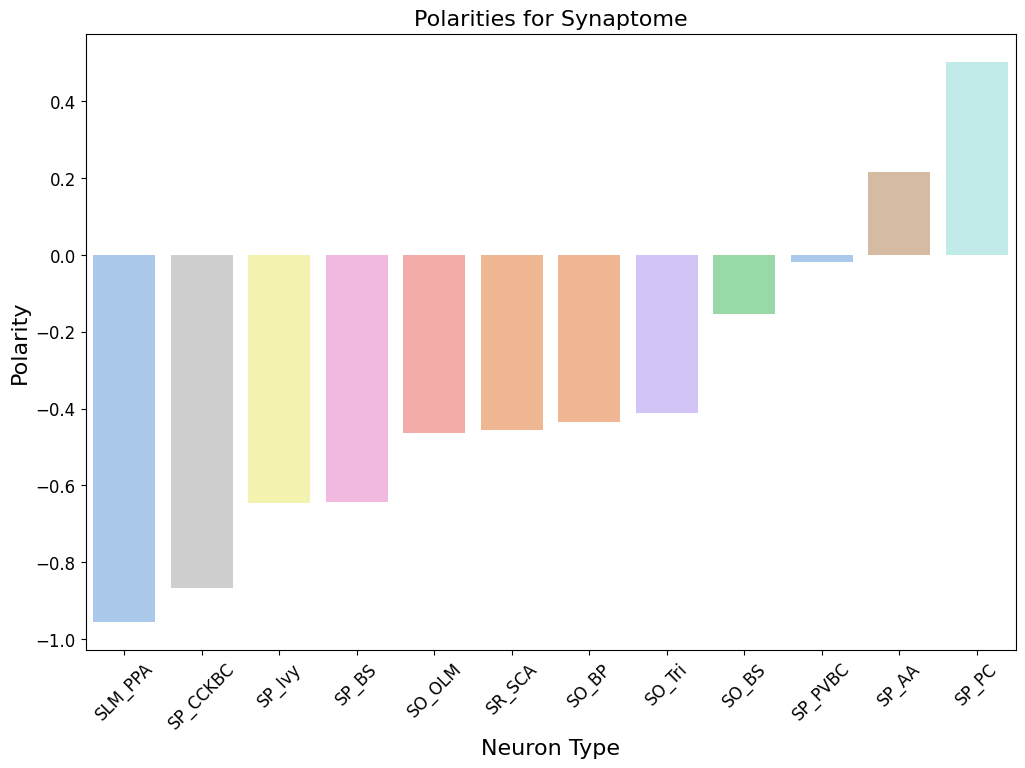

In [17]:
# Sort the DataFrame by polarity_syn column in ascending order
df_sorted_syn = df.sort_values('polarity_syn')

# Increase the figure size to accommodate the xticklabels
plt.figure(figsize=(12, 8))

# Plotting the bar plot for synapses
ax2 = sns.barplot(x=df_sorted_syn.index, y='polarity_syn', data=df_sorted_syn, palette=color_dict)

# Adding labels and title
ax2.set_xlabel('Neuron Type', fontsize=16)
ax2.set_ylabel('Polarity', fontsize=16)
ax2.set_title('Polarities for Synaptome', fontsize=16)

# Rotating the x-axis labels for better readability (if necessary)
# make ticks bigger for A0 print
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45)

# Increase the DPI for higher resolution
dpi = 600

# Save the figure with the updated figure size and DPI
plt.savefig(f'{save_dir}/polarity_syn.{file_format}', dpi=dpi, format=file_format, bbox_inches='tight')

# Displaying the plot
plt.show()
